#  **Analyze the Titanic Dataset using R**

## **Installing R in Colab**

In [37]:
!apt-get install r-base

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [38]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## **Load the dataset**

In [39]:
%%R
# Load Titanic dataset
titanic <- read.csv("/content/drive/MyDrive/titanic/train.csv")

In [40]:
%%R

# View the first few rows
head(titanic)

# View the structure of the dataset
str(titanic)


'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


## **Explore the Dataset**

In [41]:
%%R
# Summary statistics
summary(titanic)

# Check for missing values
colSums(is.na(titanic))


PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0           0           0 


## **Data cleaning**

In [42]:
%%R

# Fill missing Age with the median
titanic$Age[is.na(titanic$Age)] <- median(titanic$Age, na.rm = TRUE)

# Fill missing Embarked with the most common value
titanic$Embarked[is.na(titanic$Embarked)] <- "S"

# Verify there are no missing values left
colSums(is.na(titanic))


PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0           0 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0           0           0 


## **Perform Exploratory Data Analysis (EDA)**

Survival rate by gender

In [43]:
%%R

library(dplyr)
titanic %>%
  group_by(Sex) %>%
  summarise(Survival_Rate = mean(Survived, na.rm = TRUE))

# A tibble: 2 × 2
  Sex    Survival_Rate
  <chr>          <dbl>
1 female         0.742
2 male           0.189


Visualization: Survival by Class

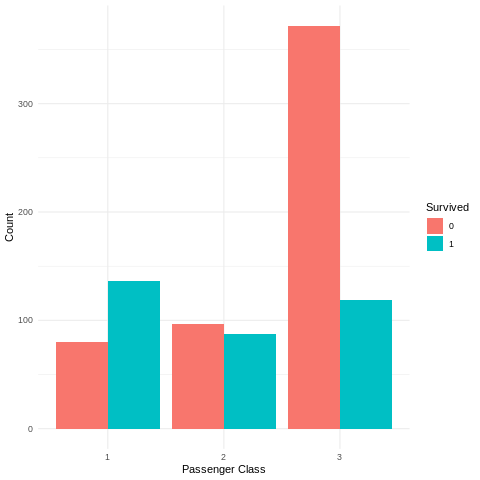

In [44]:
%%R

library(ggplot2)

# Bar plot of survival by class
ggplot(titanic, aes(x = factor(Pclass), fill = factor(Survived))) +
  geom_bar(position = "dodge") +
  labs(x = "Passenger Class", y = "Count", fill = "Survived") +
  theme_minimal()


Age Distribution

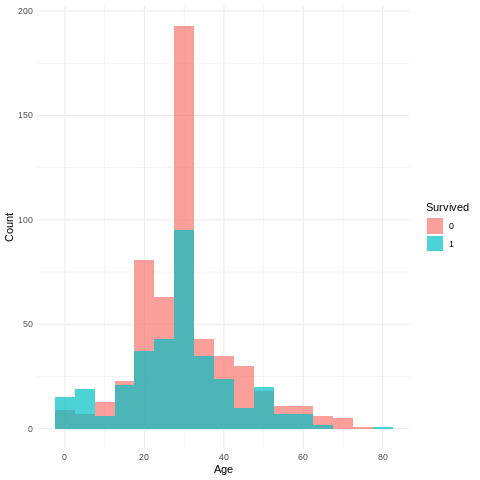

In [45]:
%%R

# Histogram of age
ggplot(titanic, aes(x = Age, fill = factor(Survived))) +
  geom_histogram(binwidth = 5, alpha = 0.7, position = "identity") +
  labs(x = "Age", y = "Count", fill = "Survived") +
  theme_minimal()

Model Immplementation

In [46]:
%%R

# Logistic regression model
model <- glm(Survived ~ Pclass + Sex + Age + Fare, data = titanic, family = "binomial")

# Summary of the model
summary(model)

# Predict survival probabilities
titanic$Predicted <- predict(model, type = "response")

# Check predictions (e.g., threshold 0.5)
titanic$Predicted_Survived <- ifelse(titanic$Predicted > 0.5, 1, 0)

# Confusion matrix
table(Predicted = titanic$Predicted_Survived, Actual = titanic$Survived)


         Actual
Predicted   0   1
        0 469  98
        1  80 244


## **Visualizations for Model Performance and Prediction Interpretation**

**1. Visualize Survival Probabilities**

`geom_smooth()` using formula = 'y ~ x'


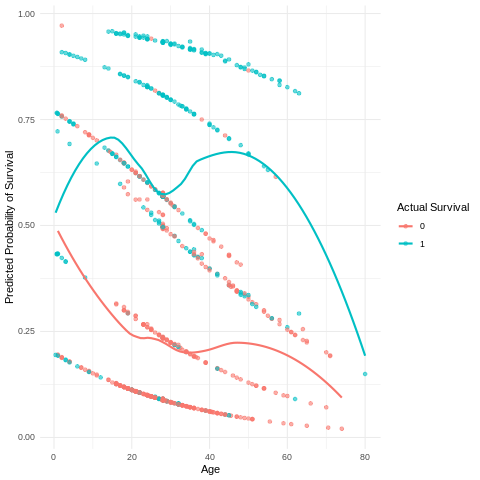

In [47]:
%%R

# Plot predicted probabilities by Age
ggplot(titanic, aes(x = Age, y = Predicted, color = factor(Survived))) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "loess", se = FALSE) +
  labs(x = "Age", y = "Predicted Probability of Survival", color = "Actual Survival") +
  theme_minimal()


**2. Model Fit Visualization**

install required packages

In [ ]:
%%R

install.packages("pROC")
library(pROC)

(as ‘lib’ is unspecified)














	‘/tmp/RtmpwuiWkL/downloaded_packages’


Attaching package: ‘pROC’



    cov, smooth, var




Plot the ROC Curve

Area under the curve: 0.8476


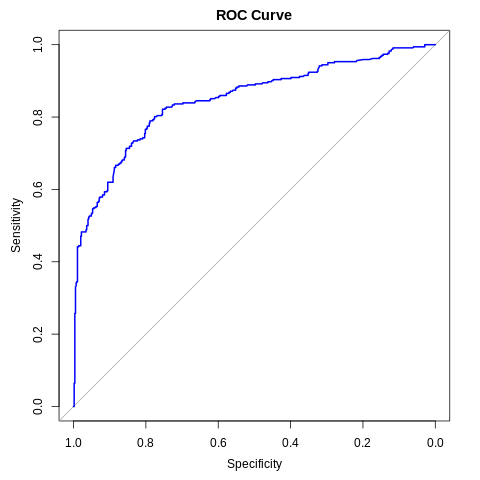

In [48]:
%%R

# Compute ROC and AUC
roc_curve <- roc(titanic$Survived, titanic$Predicted)

# Plot ROC Curve
plot(roc_curve, col = "blue", main = "ROC Curve")
auc(roc_curve)


**3. Feature Contribution Visualization**

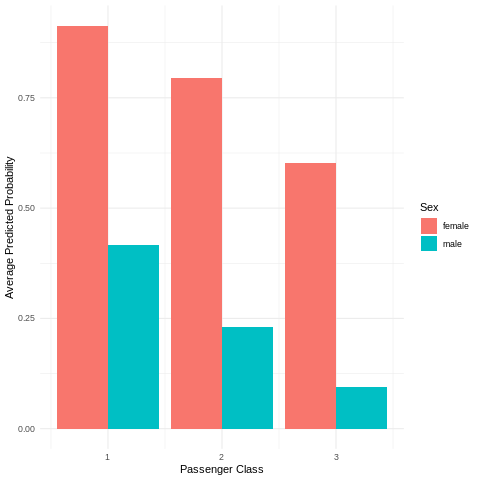

In [49]:
%%R

# Effect of Pclass and Sex on predicted probabilities
ggplot(titanic, aes(x = Pclass, y = Predicted, fill = Sex)) +
  geom_bar(stat = "summary", fun = "mean", position = "dodge") +
  labs(x = "Passenger Class", y = "Average Predicted Probability", fill = "Sex") +
  theme_minimal()


**4. Calibration Plot**

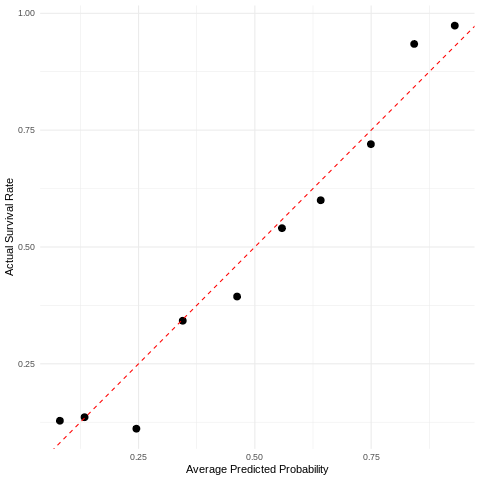

In [50]:
%%R

# Bin predictions into intervals
titanic$Prediction_Bin <- cut(titanic$Predicted, breaks = seq(0, 1, by = 0.1))

# Calculate actual survival rates per bin
calibration <- titanic %>%
  group_by(Prediction_Bin) %>%
  summarise(Average_Predicted = mean(Predicted),
            Actual_Survival = mean(Survived))

# Plot calibration
ggplot(calibration, aes(x = Average_Predicted, y = Actual_Survival)) +
  geom_point(size = 3) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(x = "Average Predicted Probability", y = "Actual Survival Rate") +
  theme_minimal()
